In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../')

## pipeline system

In [341]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline as ModelPipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from hatstall.pipes import Pipeline as CustomPipeline, PipelineSystem
from hatstall.pipes.engineer import PostsJoiner, AverageWordCalculator, Debugger
from hatstall.pipes.model import Evaluator, TestDataTokenChecker
from hatstall.pipes.loader import PersonalityPostLoader
from hatstall.pipes.preparator import (
    PostsSplitter, EvenlyDistributor, TrainTestSplitter, DigitReplacer, LinkReplacer)

In [365]:
PreparationPipeline = CustomPipeline
EvaluationPipeline = CustomPipeline

psystem = PipelineSystem([
    ('preperation', PreparationPipeline([
        ('loader', PersonalityPostLoader),
        ('splitter', PostsSplitter),
        ('evenfier', EvenlyDistributor),
        ('traintest', TrainTestSplitter)
    ])),
    ('modelling', ModelPipeline([
        ('joiner', PostsJoiner()),
        ('vect', TfidfVectorizer(max_df=1., min_df=0.01)),
        ('log', LogisticRegression(random_state=123)),
    ])),
    ('evaluation', EvaluationPipeline([
        ('eval', Evaluator)
    ]))
], mode='train_test')
psystem.run()

--- Running preparation pipeline ---
Running loader pipe --> PersonalityPostLoader
Running splitter pipe --> PostsSplitter
Ignored 5624 texts because of too small chunks
Running evenfier pipe --> EvenlyDistributor
Running traintest pipe --> TrainTestSplitter
Train size: Counter({'Introvert': 6728, 'Extrovert': 6727})
Test size: Counter({'Extrovert': 2884, 'Introvert': 2883})
--- Running modelling pipeline ---
--- Running evaluation pipeline ---
Running eval pipe --> Evaluator
0.7114617652158834
[0.72285143 0.69909584]
[[2170  713]
 [ 951 1933]]


In [366]:
# PreparationPipeline = CustomPipeline
EvaluationPipeline = CustomPipeline

psystem = PipelineSystem([
    ('preperation', PreparationPipeline([
        ('loader', PersonalityPostLoader),
        ('splitter', PostsSplitter),
        ('digit', DigitReplacer),
        ('link', LinkReplacer), 
        ('evenfier', EvenlyDistributor),
        ('traintest', TrainTestSplitter)
    ])),
    ('modelling', ModelPipeline([
        ('features', FeatureUnion([
            ('token', ModelPipeline([
                ('joiner', PostsJoiner()),
                ('vect', TfidfVectorizer(
                    max_df=1.0, min_df=0.01,
                    token_pattern='(?u)\\$?\\b\\w\\w+\\b')),
            ])),
            ('mean_word', ModelPipeline([
                ('average', AverageWordCalculator()),
                ('scaler', MinMaxScaler())
            ])),
        ])),
        ('log', LogisticRegression(random_state=123)),
    ])),
    ('evaluation', EvaluationPipeline([
#        ('token_checker', TestDataTokenChecker),
        ('eval', Evaluator)
    ]))
], mode='train_test')
psystem.run()

--- Running preparation pipeline ---
Running loader pipe --> PersonalityPostLoader
Running splitter pipe --> PostsSplitter
Ignored 5624 texts because of too small chunks
Running digit pipe --> DigitReplacer
Running link pipe --> LinkReplacer
Running evenfier pipe --> EvenlyDistributor
Running traintest pipe --> TrainTestSplitter
Train size: Counter({'Introvert': 6728, 'Extrovert': 6727})
Test size: Counter({'Extrovert': 2884, 'Introvert': 2883})
--- Running modelling pipeline ---
--- Running evaluation pipeline ---
Running token_checker pipe --> TestDataTokenChecker
Removing 2442 out of 5767 test examples because model knows to few words in test example.
Running eval pipe --> Evaluator
0.7100751879699249
[0.72186959 0.69723618]
[[1251  399]
 [ 565 1110]]


## feature chi analysis

todo
- better pipeline naming
- remove personality codes in tokens

In [401]:
from sklearn.feature_selection import chi2

temp = psystem.pipelines[2]
X, y, _, _ = temp.pipeline.payload['train_test']

model = temp.pipeline.payload['model']
matrix = model.named_steps['features'].transform(X)

feature_pipe = model.named_steps['features']
token_pipe = [x for x in feature_pipe.transformer_list if x[0] == 'token'][0][1]
feature_names = token_pipe.named_steps['vect'].get_feature_names()
feature_names = feature_names + ['$average_word_count']

chi = chi2(matrix, y)

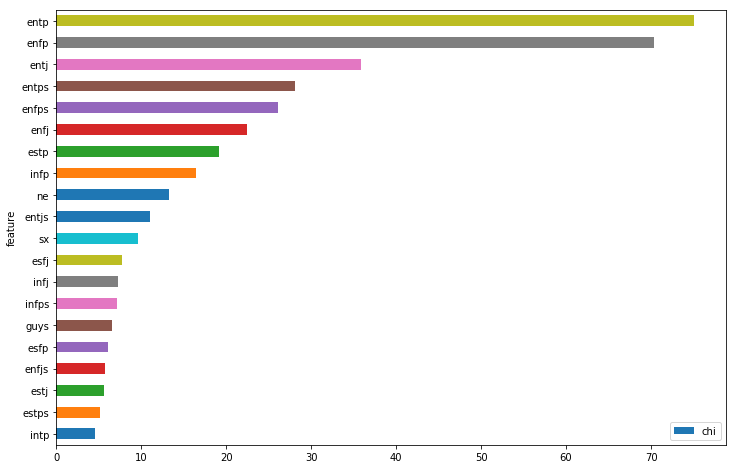

In [428]:
chidf = pd.DataFrame({'chi': chi[0], 'feature': feature_names})
chidf.sort_values('chi', ascending=False, inplace=True)
chidf.iloc[:20].iloc[::-1].plot(x='feature', y='chi', kind='barh', figsize=(12, 8))